I made a few changes. Unfortunately we were counting the same patients repeatedly so I grouped by patient and ran the classifier models. Currently it looks like they are overfitting so I will play with them some more. 

In [1]:
import numpy as np
import pandas as pd
import os
import datetime
os.getcwd()

from sklearn.model_selection import (
    GridSearchCV,
    KFold,
    train_test_split)
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier

In [47]:
projectdf = pd.read_csv('NewMemYear.csv')
conditionsdf = pd.read_csv('Conditions_ohc.csv')
chemo_pats = pd.read_csv('chemo_pats.csv')

In [48]:
chemo_pats['START'] = pd.to_datetime(chemo_pats['START'])

In [49]:
chemo_pats['MemYear'] = chemo_pats['START'].dt.strftime('%Y')

In [50]:
chemo_pats[['PATIENT', 'MemYear']].join(pd.get_dummies(chemo_pats['DESCRIPTION'])).groupby(['PATIENT', 'MemYear']).max().reset_index()

,PATIENT,MemYear,0.25 ML Leuprolide Acetate 30 MG/ML Prefilled Syringe,1 ML DOCEtaxel 20 MG/ML Injection,10 ML Doxorubicin Hydrochloride 2 MG/ML Injection,10 ML oxaliplatin 5 MG/ML Injection,100 ML Epirubicin Hydrochloride 2 MG/ML Injection,Cisplatin 50 MG Injection,Etoposide 100 MG Injection,Methotrexate 2.5 MG Oral Tablet,PACLitaxel 100 MG Injection,Paclitaxel 100 MG Injection,Tamoxifen 10 MG Oral Tablet,exemestane 25 MG Oral Tablet,neratinib 40 MG Oral Tablet,palbociclib 100 MG Oral Capsule,ribociclib 200 MG Oral Tablet
0,01541ad3-5323-cb64-96a7-c2ef42941253,1987,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0159e45d-0e1c-4108-6cf5-0107b8825389,1978,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0
2,01ece8c9-b5f1-4a9e-251c-3ee76f0739b5,1980,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0
3,02551c0a-12e2-a8d0-d756-408440072685,1965,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
4,02551c0a-12e2-a8d0-d756-408440072685,1990,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1194,ffbbfa5b-12c0-1084-d65c-bd8a03cf523a,1997,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0
1195,ffbbfa5b-12c0-1084-d65c-bd8a03cf523a,2007,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0
1196,ffbbfa5b-12c0-1084-d65c-bd8a03cf523a,2008,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0
1197,ffbbfa5b-12c0-1084-d65c-bd8a03cf523a,2009,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0


In [51]:
# Looking at specific chemo drugs -- this code creates dummies for them and groups by patient
chemo_ohc = chemo_pats[['PATIENT', 'MemYear']].join(pd.get_dummies(chemo_pats['DESCRIPTION'])).groupby(['PATIENT', 'MemYear']).max().reset_index()

In [52]:
projectdf.drop(['emergency', 'inpatient', 'outpatient', 'urgentcare', 'wellness', 'ER_Visits', 'Inpt_Admits'], axis=1, inplace=True)

In [53]:
# Group all the patient info into one line for each patient
projectdf = projectdf.groupby(['PATIENT', 'MemYear']).max()

In [54]:
projectdf.reset_index(inplace = True)

In [59]:
chemo_ohc['MemYear'] = chemo_ohc['MemYear'].astype('int')

In [58]:
projectdf.dtypes

PATIENT                                                                              object
MemYear                                                                               int64
Unnamed: 0                                                                            int64
Carcinoma in situ of prostate (disorder)                                              int64
Malignant neoplasm of breast (disorder)                                               int64
Malignant tumor of colon                                                              int64
Metastasis from malignant tumor of prostate (disorder)                                int64
Neoplasm of prostate                                                                  int64
Non-small cell carcinoma of lung  TNM stage 1 (disorder)                              int64
Non-small cell lung cancer (disorder)                                                 int64
Primary malignant neoplasm of colon                                             

In [60]:
# Add the one hot encoded chemo drugs to the conditions df.
projectdf = projectdf.merge(chemo_ohc, on = ['PATIENT', 'MemYear'], how = 'left')

In [62]:
# Assess for null values and fill null conditions with '0'
projectdf.isnull().sum()
projectdf.fillna(0, inplace=True)

In [72]:
Y = projectdf['Chronic congestive heart failure (disorder)']
X = projectdf.drop(['Chronic congestive heart failure (disorder)', 'PATIENT', 'MemYear', 'Unnamed: 0'], axis=1)

In [73]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.30, random_state=42)

In [74]:
from sklearn.linear_model import Lasso

In [75]:
rfc = RandomForestClassifier(random_state=42)
rfc.get_params()

param_grid = {
            'max_depth': [5, 10, 15, 20, 25],
            'n_estimators': [10, 15, 25, 50, 100],
            'n_jobs': [-1]}

cv = KFold(n_splits=5)



In [76]:
cv_mod = GridSearchCV(rfc, param_grid=param_grid, cv=cv)

In [77]:
gridcv = cv_mod.fit(X_train, Y_train)
gridcv.best_params_

{'max_depth': 15, 'n_estimators': 50, 'n_jobs': -1}

In [71]:
X_train

,PATIENT,MemYear,Unnamed: 0,Carcinoma in situ of prostate (disorder),Malignant neoplasm of breast (disorder),Malignant tumor of colon,Metastasis from malignant tumor of prostate (disorder),Neoplasm of prostate,Non-small cell carcinoma of lung TNM stage 1 (disorder),Non-small cell lung cancer (disorder),...,Cisplatin 50 MG Injection,Etoposide 100 MG Injection,Methotrexate 2.5 MG Oral Tablet,PACLitaxel 100 MG Injection,Paclitaxel 100 MG Injection,Tamoxifen 10 MG Oral Tablet,exemestane 25 MG Oral Tablet,neratinib 40 MG Oral Tablet,palbociclib 100 MG Oral Capsule,ribociclib 200 MG Oral Tablet
4774,ec43182d-169c-8490-88d7-b0ae1dc7df38,2012,4774,0,0,0,0,0,1,1,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2974,856f9aac-e1bf-ca04-14f4-840d3acea4ac,1980,2974,0,1,0,0,0,0,0,...,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0
2462,6f60d183-2b8d-8c3c-77d0-2b684653651e,1991,2462,1,0,0,0,1,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
622,198670b2-4ae7-a613-5723-5db0aaaa4d04,1986,622,0,0,0,0,0,1,1,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2577,726e09f8-adf9-1752-4436-344cc32ac6ee,1978,2577,0,0,0,0,0,0,0,...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3092,89975c92-669d-3c1c-fc93-5b4aea094719,1983,3092,0,0,0,1,1,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3772,b7c5b161-8cb9-2348-b1e3-5acd92e6447b,2004,3772,0,1,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5191,fcfd49f2-5e59-1299-7466-25366ddfa1ff,1994,5191,1,0,0,0,1,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5226,fe47f88d-4c6a-308e-46bb-ffe899aba1c8,1999,5226,1,0,0,0,1,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


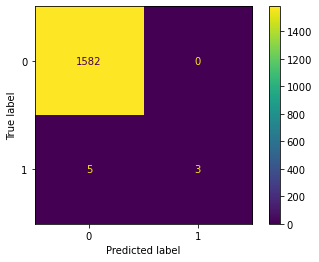

In [78]:
_ = ConfusionMatrixDisplay.from_estimator(gridcv.best_estimator_, X_test, Y_test)

In [79]:
ada = AdaBoostClassifier(random_state=42)
ada.get_params()

param_grid = {
            'learning_rate': [0.5, 0.8, 15],
            'n_estimators': [10, 15, 25, 50, 100],
            'n_jobs': [-1]}

cv = KFold(n_splits=5)


In [80]:
adacv_mod = GridSearchCV(ada, param_grid=param_grid, cv=cv)

In [81]:
adagridcv = cv_mod.fit(X_train, Y_train)
adagridcv.best_params_

{'max_depth': 15, 'n_estimators': 50, 'n_jobs': -1}

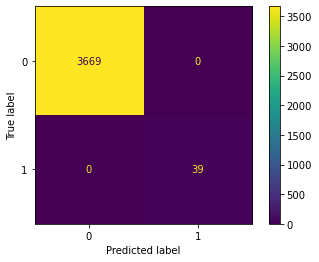

In [82]:
_ = ConfusionMatrixDisplay.from_estimator(adagridcv.best_estimator_, X_train, Y_train)

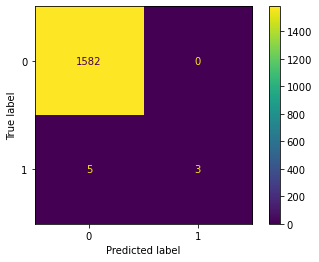

In [83]:
_ = ConfusionMatrixDisplay.from_estimator(adagridcv.best_estimator_, X_test, Y_test)

In [85]:
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    ConfusionMatrixDisplay,
    plot_confusion_matrix,
    accuracy_score,
    plot_roc_curve,
    precision_score,
    recall_score,
    RocCurveDisplay
)
from sklearn.model_selection import (
    GridSearchCV,
    KFold,
    train_test_split
)
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC

import datetime

#from utils import plot_decision_boundary

In [89]:
k_fold = KFold(n_splits=2, shuffle=True, random_state=42) #setting up our number of folds

In [88]:
#logspace-- what power base 10 are we raising to
C_candidates = np.logspace(-2, 0, 20) #Grid of 20 points between 10^-2 and 10^0 (which is 1)
gamma_candidates = np.logspace(-2, 1, 20) #Grid of 20 points between 10^-2 and 10^1 (which is 10)

In [90]:
svm_pipeline = make_pipeline(StandardScaler(), #Scaling features-- want to make sure our distance computations are dominated by predictors that have large variability
                             SVC(random_state=42))

In [91]:
#Looking in a "box" 20 points on gamma axis (depth) and 20 points on x? axis (width); either way 400 candidates total
grid_search_cv = GridSearchCV(svm_pipeline, 
                              dict(svc__C=C_candidates, svc__gamma=gamma_candidates), #C parameter is the marginal regularlization strength
                              cv=k_fold).fit(X_train, Y_train) #two folds defined above

In [92]:
grid_search_cv.best_params_

{'svc__C': 0.615848211066026, 'svc__gamma': 0.01}

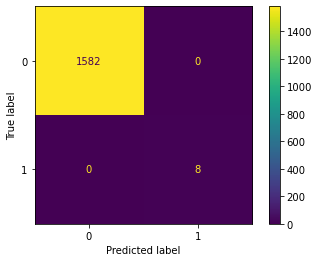

In [93]:
_ = ConfusionMatrixDisplay.from_estimator(grid_search_cv.best_estimator_, X_test, Y_test)

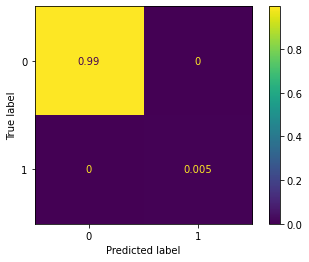

In [94]:
_ = ConfusionMatrixDisplay.from_estimator(grid_search_cv.best_estimator_, X_test, Y_test, normalize='all')

In [95]:
precision_score(Y_test, grid_search_cv.best_estimator_.predict(X_test))

1.0

In [96]:
recall_score(Y_test, grid_search_cv.best_estimator_.predict(X_test))

1.0

In [97]:
accuracy_score(Y_test, grid_search_cv.best_estimator_.predict(X_test))

1.0

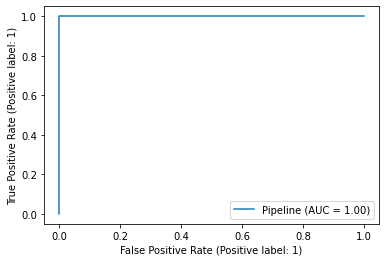

In [98]:
_ = RocCurveDisplay.from_estimator(grid_search_cv.best_estimator_, X_test, Y_test)

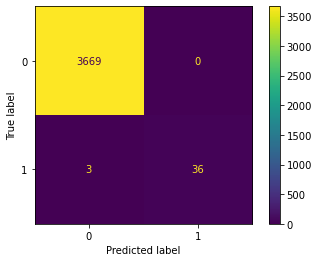

In [99]:
_ = ConfusionMatrixDisplay.from_estimator(grid_search_cv.best_estimator_, X_train, Y_train)

In [100]:
recall_score(Y_train, grid_search_cv.best_estimator_.predict(X_train))

0.9230769230769231